In [1]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN
import os
from model.utils import train, device
import torch
import numpy as np
import pandas as pd

In [2]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os



class OpenCloseDataset(Dataset):

    def __init__(self, datafolder, test=False, transform=None, pre_transform=None, k_degree=10):

        self.test = test
        self.datafolder = datafolder
        self.open = np.load(f'{datafolder}/raw/open_sorted.npy')
        self.close = np.load(f'{datafolder}/raw/close_sorted.npy')
        self.edge_attr = np.load(f'{datafolder}/edge_attr.npy')
        self.k_degree = k_degree

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['close_sorted.npy', 'open_sorted.npy']

    @property
    def processed_file_names(self):

        """ If these files are found in raw_dir, processing is skipped"""
        # todo test filenames
        if self.test:
            return [os.path.join(self.datafolder, 'processed', 'test', f'data_{i}.pt') for i in range(47+47)]

        else:
            return [os.path.join(self.datafolder, 'processed', f'data_{i}.pt') for i in range(47+47)]

    def download(self):
        pass

    def process(self):

        for index, matr in enumerate(self.open):
            _ = self._load_and_save(matr, index, 'open')

        for index, matr in enumerate(self.close):
            _ = self._load_and_save(matr, index, 'close')

    def _load_and_save(self, matr, index, state):

        x = torch.from_numpy(matr).float()

        if self.k_degree is not None:
            adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
            adj = torch.from_numpy(adj).float()
            edge_index, edge_attr = dense_to_sparse(adj)
        else:
            edge_index = self._adjacency_threshold(x)

        label = torch.tensor(0 if state == 'close' else 1).long()

        data = Data(x=x, edge_index=edge_index, y=label) # , edge_attr=self.edge_attr

        index = index + 47 if state == 'close' else index
        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test',
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data

    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def _adjacency_threshold(self, matr, threshold=0.5):

        idx = []
        for i in range(len(matr)):
            for j in range(len(matr)):
                if abs(matr[i, j]) > threshold:
                    idx.append((i, j))

        return torch.tensor(idx).long().t().contiguous()

    def len(self):
        return 47+47  # len(self.files)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data

In [18]:
full_dataset = OpenCloseDataset(datafolder='../data', k_degree=30).shuffle()
len(os.listdir('../data/processed'))

Processing...
Done!


96

In [19]:
full_dataset[0]

Data(x=[420, 420], edge_index=[2, 16416], y=1)

In [20]:
train_size = int(0.94 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]
val_dataset, test_dataset = val_dataset[:-3], val_dataset[-3:]

In [21]:
len(val_dataset)

3

In [22]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

class GCN(nn.Module):
    def __init__(self,
                 num_features,
                 num_classes,
                 channels,
                 dropout=0):
        super().__init__()

        self.p = dropout
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.conv3 = GCNConv(channels[1], channels[2])

        self.lin1 = nn.Linear(channels[2], int(num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        #print(x.shape)
        x = F.relu(self.conv1(x, edge_index)) #
        #print(x.shape)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        x = F.relu(self.conv3(x, edge_index))
        #print(x.shape)
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.lin1(x)
        return x

In [29]:
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def eval_epoch(loader, model, criterion):
    model.eval()
    losses = 0
    correct = 0
    pr = []
    rc = []
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data)
            loss = criterion(out, data.y)
            losses += loss.item()
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            #print(pred)
            #print(data.y)

            pr.append(precision_score(data.y, pred, zero_division=0))
            rc.append(recall_score(data.y, pred, zero_division=0))
        # Derive ratio of correct predictions.
    return losses / len(loader.dataset), correct / len(loader.dataset), np.mean(pr), np.mean(rc)

def train(model, epochs, train_loader, val_loader, criterion, optimizer):
    losses = []
    for epoch in tqdm(range(1, epochs)):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        losses.append((train_loss, val_loss))
    return losses

In [30]:
from torch.optim import lr_scheduler
model = GCN(full_dataset.num_features, 2, channels=[256, 32, 8], dropout=0.1).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 20
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


116282

In [31]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [32]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer)

  5%|▌         | 1/19 [00:13<04:05, 13.63s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 001, Train Loss: 0.0866, Test Loss 0.2277, Train Acc: 0.5000, Test Acc: 0.6667


 11%|█         | 2/19 [00:26<03:43, 13.17s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 002, Train Loss: 0.0864, Test Loss 0.2273, Train Acc: 0.5000, Test Acc: 0.6667


 16%|█▌        | 3/19 [00:40<03:39, 13.73s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 003, Train Loss: 0.0868, Test Loss 0.2305, Train Acc: 0.5114, Test Acc: 0.6667


 21%|██        | 4/19 [00:54<03:25, 13.68s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 004, Train Loss: 0.0866, Test Loss 0.2285, Train Acc: 0.5000, Test Acc: 0.6667


 26%|██▋       | 5/19 [01:07<03:07, 13.38s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 005, Train Loss: 0.0866, Test Loss 0.2287, Train Acc: 0.5000, Test Acc: 0.6667


 32%|███▏      | 6/19 [01:20<02:53, 13.32s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 006, Train Loss: 0.0866, Test Loss 0.2287, Train Acc: 0.5000, Test Acc: 0.6667


 37%|███▋      | 7/19 [01:33<02:39, 13.27s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 007, Train Loss: 0.0865, Test Loss 0.2288, Train Acc: 0.5000, Test Acc: 0.6667


 42%|████▏     | 8/19 [01:45<02:20, 12.81s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 008, Train Loss: 0.0865, Test Loss 0.2287, Train Acc: 0.5000, Test Acc: 0.6667


 47%|████▋     | 9/19 [01:58<02:07, 12.75s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 009, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 53%|█████▎    | 10/19 [02:10<01:52, 12.50s/it]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 010, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 58%|█████▊    | 11/19 [02:21<01:38, 12.26s/it]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 011, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 63%|██████▎   | 12/19 [02:35<01:29, 12.83s/it]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 012, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 68%|██████▊   | 13/19 [02:48<01:16, 12.77s/it]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 013, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 74%|███████▎  | 14/19 [03:07<01:12, 14.50s/it]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 014, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 79%|███████▉  | 15/19 [03:25<01:02, 15.55s/it]

Adjusting learning rate of group 0 to 1.0000e-06.
Epoch: 015, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 84%|████████▍ | 16/19 [03:38<00:44, 14.86s/it]

Adjusting learning rate of group 0 to 1.0000e-06.
Epoch: 016, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 89%|████████▉ | 17/19 [03:51<00:28, 14.33s/it]

Adjusting learning rate of group 0 to 1.0000e-06.
Epoch: 017, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


 95%|█████████▍| 18/19 [04:04<00:13, 13.83s/it]

Adjusting learning rate of group 0 to 1.0000e-06.
Epoch: 018, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


100%|██████████| 19/19 [04:16<00:00, 13.50s/it]

Adjusting learning rate of group 0 to 1.0000e-06.
Epoch: 019, Train Loss: 0.0865, Test Loss 0.2289, Train Acc: 0.5000, Test Acc: 0.6667


In [33]:
train_loss, val_loss = zip(*history)

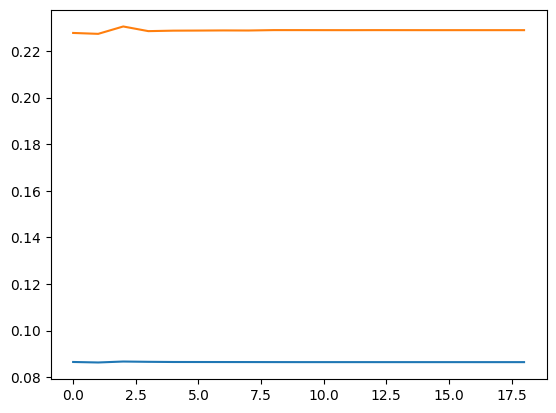

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
#plt.plot(acc)
#plt.plot(pres)

In [49]:
torch.save(model.state_dict(), '../weights/bs8_256_32_32_None.pt')

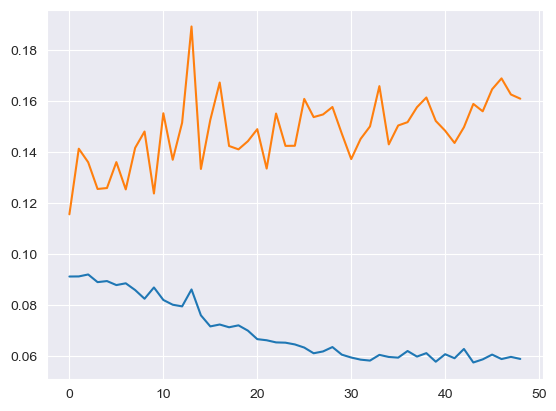

In [134]:
plt.plot(train_loss)
plt.plot(val_loss)

In [135]:
torch.save(model.state_dict(), '../weights/bs8_128_32_8_k5.pt')

In [50]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 4))

labels = [full_dataset[i].y for i in range(len(full_dataset))]

for n_fold, (train_idx, test_idx) in enumerate(skf.split(labels, labels)):
    model = GCN(full_dataset.num_features, 2, channels=[256, 32, 32], dropout=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print()
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(11):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, train_pr, train_rc = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, val_pr, val_rc = eval_epoch(val_loader, model, criterion)
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        rc.append(val_rc)
        pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = np.mean(pr)
    eval_metrics[n_fold, 1] = np.mean(rc)
    eval_metrics[n_fold, 2] = np.mean(acc)
    eval_metrics[n_fold, 3] = best_test_acc


0
Epoch: 000, Train Loss: 0.0901, Test Loss 0.3478, Train Acc: 0.5714, Test Acc: 0.5000
Train Prec: 0.598, Train Rec: 0.282, Test Prec: 0.200, Test Rec: 0.200
Epoch: 001, Train Loss: 0.0906, Test Loss 0.3568, Train Acc: 0.5119, Test Acc: 0.4000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 002, Train Loss: 0.0895, Test Loss 0.3494, Train Acc: 0.5357, Test Acc: 0.4000
Train Prec: 0.182, Train Rec: 0.053, Test Prec: 0.000, Test Rec: 0.000
Epoch: 003, Train Loss: 0.0886, Test Loss 0.3574, Train Acc: 0.5238, Test Acc: 0.4000
Train Prec: 0.091, Train Rec: 0.030, Test Prec: 0.000, Test Rec: 0.000
Epoch: 004, Train Loss: 0.0877, Test Loss 0.3517, Train Acc: 0.5595, Test Acc: 0.4000
Train Prec: 0.409, Train Rec: 0.185, Test Prec: 0.000, Test Rec: 0.000
Epoch: 005, Train Loss: 0.0884, Test Loss 0.3405, Train Acc: 0.7619, Test Acc: 0.6000
Train Prec: 0.638, Train Rec: 0.808, Test Prec: 0.600, Test Rec: 0.600
Epoch: 006, Train Loss: 0.0874, Test Loss 0.3595, Train

In [51]:
eval_metrics

array([[0.19090909, 0.19090909, 0.48181818, 0.6       ],
       [0.37272727, 0.42727273, 0.55454545, 0.6       ],
       [0.26363636, 0.29090909, 0.5       , 0.6       ],
       [0.07272727, 0.09090909, 0.42727273, 0.6       ],
       [0.3       , 0.29090909, 0.52727273, 0.6       ],
       [0.12727273, 0.12727273, 0.44545455, 0.6       ],
       [0.05454545, 0.04545455, 0.41818182, 0.4       ],
       [0.16363636, 0.19090909, 0.46363636, 0.6       ],
       [0.22727273, 0.25454545, 0.5       , 0.7       ],
       [0.23636364, 0.28181818, 0.48181818, 0.6       ]])